In [1]:
import os
os.chdir(r'7 - Putting it together')
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path
import music21 as m21
musescore_path = '/usr/bin/mscore'
m21.environment.set('musicxmlPath', musescore_path)
m21.environment.set('musescoreDirectPNGPath', musescore_path)
from midi_encoding import *
from data_loading import *
from model import *

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device}.")

Using cuda.


In [2]:
!nvidia-smi

Sun Sep 22 20:18:35 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.02              Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        On  |   00000000:01:00.0  On |                  Off |
| 30%   30C    P0             45W /  450W |    4965MiB /  24564MiB |     34%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
dataset_name = 'lakh_clean_piano'
midi_path = Path(f'../data/midi/{dataset_name}')
score_path = Path(f'../data/numpy/{dataset_name}')
midi_file_paths = list(midi_path.rglob('*.mid')) #[f for f in os.listdir(midi_path) if os.path.isfile(os.path.join(midi_path, f))]

# Ensure files are shuffled directly after assignment.
# If they are shuffled in a different cell, and that cell is run multiple times, the order will change as we are shuffling the already-shuffled list.
random.seed(42)
random.shuffle(midi_file_paths)

len(midi_file_paths)

16977

In [4]:
n1 = int(0.8 * len(midi_file_paths))
n2 = int(0.9 * len(midi_file_paths))
train_filepaths = midi_file_paths[:n1]
valid_filepaths = midi_file_paths[n1:n2]
test_filepaths = midi_file_paths[n2:]

print(f'Train file names: {len(train_filepaths)}, Valid file names: {len(valid_filepaths)}, Test file names: {len(test_filepaths)}')

Train file names: 13581, Valid file names: 1698, Test file names: 1698


In [5]:
max_vocab_size = 389
vocab_name = f'{dataset_name}-actions_{max_vocab_size}'
vocab_state_dict_path = Path(f'../data/vocab/{vocab_name}.pkl')

MidiDataset says "Look for the given filenames at the given score path. Load if they exist, if not create them'.

We can use this to encode with the trained vocab if we pass it in as a param.

In [6]:
sample_length = 256
max_file_length = 32

if not vocab_state_dict_path.exists():
    
    # Load (and / or create) dataset of unmerged samples
    untrained_vocab = MusicVocab()
    untrained_vocab_size = untrained_vocab.initial_size
    untrained_vocab.train(None, untrained_vocab_size) # Required to init actions, not adding any tokens
    print(f'Untrained vocab size: {untrained_vocab_size}')
    vocab_training_dataset = MidiDataset(untrained_vocab, midi_file_paths, score_path, sample_length, max_file_length)
    print(f"Loading unmerged samples...")
    vocab_training_dataset.load_samples("cpu")

    # Train the vocab on the unmerged dataset, so it can learn the merges
    print(f"Training vocab, adding {max_vocab_size - untrained_vocab_size} tokens...")
    trained_vocab = MusicVocab()
    trained_vocab.train(vocab_training_dataset, max_vocab_size=max_vocab_size)
    print(f'Trained vocab size: {trained_vocab.size}')
    print(f"Saving vocab with actions:\n{trained_vocab.actions}")
    trained_vocab.save(vocab_state_dict_path)
else:
    print(f"Loading vocab...")
    trained_vocab = MusicVocab()
    trained_vocab.load(vocab_state_dict_path)
    print(f"Loaded vocab with actions:\n{trained_vocab.actions}")
    print(f'Trained vocab size: {trained_vocab.size}')

Loading vocab...
Loaded vocab with actions:
[]
Trained vocab size: 389


In [7]:
merged_score_path = Path(f'../data/numpy/{vocab_name}')
os.makedirs(merged_score_path, exist_ok=True)

# Use the trained vocab to load GPU datasets, which will create merged samples if we pass a new path
train_dataset = MidiDataset(trained_vocab, train_filepaths, merged_score_path, sample_length, max_file_length)
valid_dataset = MidiDataset(trained_vocab, valid_filepaths, merged_score_path, sample_length, max_file_length)
test_dataset = MidiDataset(trained_vocab, test_filepaths, merged_score_path, sample_length, max_file_length)

print(f'Loading train samples')
train_dataset.load_samples(device)

print(f'Loading valid samples')
valid_dataset.load_samples(device)

print(f'Loading test samples')
test_dataset.load_samples(device)

Loading train samples
Encoding


/opt/conda/lib/python3.10/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'\x94\xfc\x8f\xad\x8f\x97\x90\xed\x8em\xbe\xb0\xd7\xb0\xd1\xb0\xdd\xa5\xbe\xb0\xd7\xb0\xbd\xc0\xb0\xbd\xde \xb5\xb0\xcc\xdf\xc6\xdd\xb8\xde \xa2\x83Z\x81[\x83\x89\x81[\x83X\x83^\x81[\x83\\\x83\x93\x83O\xa3<GS> '>; getting generic Instrument
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'\x94\xfc\x8f\xad\x8f\x97\x90\xed\x8em\xbe\xb0\xd7\xb0\xd1\xb0\xdd\xa5\xbe\xb0\xd7\xb0\xbd\xc0\xb0\xbd\xde \xb5\xb0\xcc\xdf\xc6\xdd\xb8\xde \xa2\x83Z\x81[\x83\x89\x81[\x83X\x83^\x81[\x83\\\x83\x93\x83O\xa3<GS> '>; getting generic Instrument
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/music21/midi/translate.py:874: TranslateWarnin

Encoded
Loading valid samples
Encoding


/opt/conda/lib/python3.10/site-packages/torch/nested/__init__.py:166: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905979055/work/aten/src/ATen/NestedTensorImpl.cpp:178.)
  return _nested.nested_tensor(
/opt/conda/lib/python3.10/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'M\xe9lodie'>; getting generic Instrument
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Fl\x84che  '>; getting generic Instrument
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRAC

Encoded
Loading test samples
Encoding


/opt/conda/lib/python3.10/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'Teclado B\xe1sico 1'>; getting generic Instrument
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'Teclado B\xe1sico 2'>; getting generic Instrument
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=6, channel=None, data=b'Tout Droits R\xe9erv\xe9es'>; getting generic Instrument
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None,

Encoded


In [8]:
print(f'Train files: {len(train_dataset.file_lengths)}, Valid files: {len(valid_dataset.file_lengths)}, Test files: {len(test_dataset.file_lengths)}')

Train files: 5716, Valid files: 708, Test files: 667


In [9]:
# Batch size can be changed for a second phase of training quite quickly, it only requires re-computing the indices, not re-loading the data.
batch_size = 32
train_sampler = ContiguousBatchSampler(train_dataset)
valid_sampler = ContiguousBatchSampler(valid_dataset)
test_sampler = ContiguousBatchSampler(test_dataset)

print(f'Precomputing indices')
train_sampler.precompute_indices(batch_size)
valid_sampler.precompute_indices(batch_size)
test_sampler.precompute_indices(batch_size)

train_data_loader = DataLoader(train_dataset, batch_sampler=train_sampler)
valid_data_loader = DataLoader(valid_dataset, batch_sampler=valid_sampler)
test_data_loader = DataLoader(test_dataset, batch_sampler=test_sampler)

Precomputing indices


In [10]:
model_name = f'midi_transformer_knn-xl_{vocab_name}'
model_load_path = Path(f'../data/checkpoints/{model_name}.dat')
model_save_path = Path(f'../data/checkpoints/{model_name}.dat')
log_dir = Path(f'../tensorboard/{model_name}')
tensorboard_writer = SummaryWriter(log_dir)

In [11]:
model = DecoderTransformer_KNN_XL(vocab=trained_vocab, sample_length=sample_length, max_file_length=max_file_length, device=device, use_knn=True, n_embed=384, n_head=6, n_layer=6)

print(sum(p.numel() for p in model.parameters()))

11345675


In [12]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
token_embedding.weight 	 torch.Size([389, 384])
rel_pos.relative_attention_embedding.weight 	 torch.Size([32, 6])
rel_pos_knn.relative_attention_embedding.weight 	 torch.Size([32, 6])
beat_embedding.weight 	 torch.Size([32, 384])
bar_embedding.weight 	 torch.Size([1024, 384])
blocks.0.attention.key.weight 	 torch.Size([384, 384])
blocks.0.attention.query.weight 	 torch.Size([384, 384])
blocks.0.attention.value.weight 	 torch.Size([384, 384])
blocks.0.attention.project.weight 	 torch.Size([384, 384])
blocks.0.attention.project.bias 	 torch.Size([384])
blocks.0.ff.net.0.weight 	 torch.Size([1536, 384])
blocks.0.ff.net.0.bias 	 torch.Size([1536])
blocks.0.ff.net.3.weight 	 torch.Size([384, 1536])
blocks.0.ff.net.3.bias 	 torch.Size([384])
blocks.0.layer_norm1.weight 	 torch.Size([384])
blocks.0.layer_norm1.bias 	 torch.Size([384])
blocks.0.layer_norm2.weight 	 torch.Size([384])
blocks.0.layer_norm2.bias 	 torch.Size([384])
blocks.1.attention.key.weight 	 torch.Size([38

In [13]:
learning_rate = 3e-4
weight_decay = 1e-3
eval_iters = 100

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

@torch.no_grad()
def estimate_loss(data_loader):
    model.eval()
        
    xl_memories = None
    losses = torch.zeros(eval_iters)
    
    # Not working
    # Start at a random point in the data, making sure we have enough data to evaluate
    # offset = random.randint(0, len(data_loader.dataset) - (eval_iters + 1))
    # data_iter = itertools.islice(iter(data_loader), offset, None)

    data_iter = iter(data_loader)

    for k in range(eval_iters):
        file_idxs, batch = next(data_iter)
        X, Y = batch[:, :-1], batch[:, 1:, 0] # drop absolute position from Y
        _, loss, xl_memories = model(file_idxs, X, xl_memories, Y)
        losses[k] = loss.item()

    model.train()
    
    return losses.mean()

In [14]:
average_log_losses = {  
    "train" : [],
    "val" : []
}

epochs = 0

def save_checkpoint(iterations):
    train_loss = estimate_loss(train_data_loader)
    val_loss = estimate_loss(valid_data_loader)
    tensorboard_writer.add_scalar('Loss/train', train_loss, iterations)
    tensorboard_writer.add_scalar('Loss/val', val_loss, iterations)
    train_log_loss = train_loss.log10().item()
    val_log_loss = val_loss.log10().item()
    average_log_losses['train'].append(train_log_loss)
    average_log_losses['val'].append(val_log_loss)
    print(f'Epoch {epochs} / Iteration {iterations}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    torch.save({
        'iter': iterations,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'vocab_state_dict': trained_vocab.state_dict(),
        'losses': average_log_losses,
        'epochs': epochs
    }, model_save_path)

In [15]:
eval_interval = 200
total_iterations = 100000
start_iter = 0

if model_load_path.exists():
    checkpoint = torch.load(model_load_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    average_log_losses = checkpoint['losses']
    iterations = checkpoint['iter']
    epochs = checkpoint['epochs']
    start_iter = iterations + 1
    print(f"Loaded model from iteration {iterations}")

In [16]:
model.train()

remaining_iters = total_iterations - start_iter
if remaining_iters != -1:

    print(f"Training from epoch {epochs} for {remaining_iters} iterations")
    
    xl_memories = None
    initial_file_idxs = None
    train_data = iter(train_data_loader)
    offset_iter = start_iter

    for iteration in range(remaining_iters):
        offset_iter = iteration + start_iter

        if offset_iter % eval_interval == 0:
            # Because we don't explicitly clear xl and knn mem here, there is always a risk that the eval loop leaves the file idx
            # the same as the train loop, but with memories of the 'future' which aren't cleared. It could also break the epoch counter.
            # The risk would be much smaller with a bigger data set, but with vg_large we loop through the data quite quickly.
            save_checkpoint(offset_iter)

        # Configure minibatch
        file_idxs, batch = next(train_data)

        if initial_file_idxs is None:
            initial_file_idxs = file_idxs

        if torch.equal(initial_file_idxs, file_idxs):
            epochs += 1
        
        X, Y = batch[:, :-1], batch[:, 1:, 0]

        # Forward pass
        logits, loss, xl_memories = model(file_idxs, X, xl_memories, Y)

        # Backward pass
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    save_checkpoint(offset_iter + 1)

Training from epoch 0 for 100000 iterations


/opt/conda/lib/python3.10/site-packages/faiss/contrib/torch_utils.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  x.storage().data_ptr() + x.storage_offset() * 4)


Epoch 0 / Iteration 0: Train Loss: 6.2417, Val Loss: 6.2438
Epoch 13 / Iteration 200: Train Loss: 2.5781, Val Loss: 2.5411
Epoch 13 / Iteration 400: Train Loss: 2.5125, Val Loss: 2.4832
Epoch 13 / Iteration 600: Train Loss: 2.4706, Val Loss: 2.4264
Epoch 13 / Iteration 800: Train Loss: 2.3823, Val Loss: 2.3542
Epoch 13 / Iteration 1000: Train Loss: 2.2860, Val Loss: 2.2515
Epoch 13 / Iteration 1200: Train Loss: 2.1303, Val Loss: 2.0927
Epoch 13 / Iteration 1400: Train Loss: 1.9991, Val Loss: 1.9601
Epoch 13 / Iteration 1600: Train Loss: 1.9480, Val Loss: 1.9172
Epoch 13 / Iteration 1800: Train Loss: 1.8922, Val Loss: 1.8585
Epoch 13 / Iteration 2000: Train Loss: 1.8603, Val Loss: 1.8307
Epoch 13 / Iteration 2200: Train Loss: 1.8401, Val Loss: 1.8144
Epoch 13 / Iteration 2400: Train Loss: 1.8166, Val Loss: 1.7881
Epoch 13 / Iteration 2600: Train Loss: 1.8088, Val Loss: 1.7826
Epoch 13 / Iteration 2800: Train Loss: 1.7878, Val Loss: 1.7615
Epoch 13 / Iteration 3000: Train Loss: 1.7912, V

KeyboardInterrupt: 

In [17]:
print('Final training loss:', 10 ** average_log_losses['train'][-1])

In [18]:
print('Final validation loss:', 10 ** average_log_losses['val'][-1])

In [19]:
plt.plot(average_log_losses['train'][1:])

In [20]:
plt.plot(average_log_losses['val'][1:])

In [33]:
init_idx = torch.zeros((1,1,2), dtype=torch.long, device=device)
generated_tokens = model.generate(init_idx, max_new_tokens=512).cpu()

In [34]:
generated_tokens.shape

In [37]:
trained_vocab.itos[0]

In [63]:
score = generated_tokens[0, :, 0]
trained_vocab.to_tokens(score.tolist())

In [64]:
generated_stream = idx_to_stream_enc(np.array(score), trained_vocab)
generated_stream.plot()

In [41]:
generated_stream.show('midi')

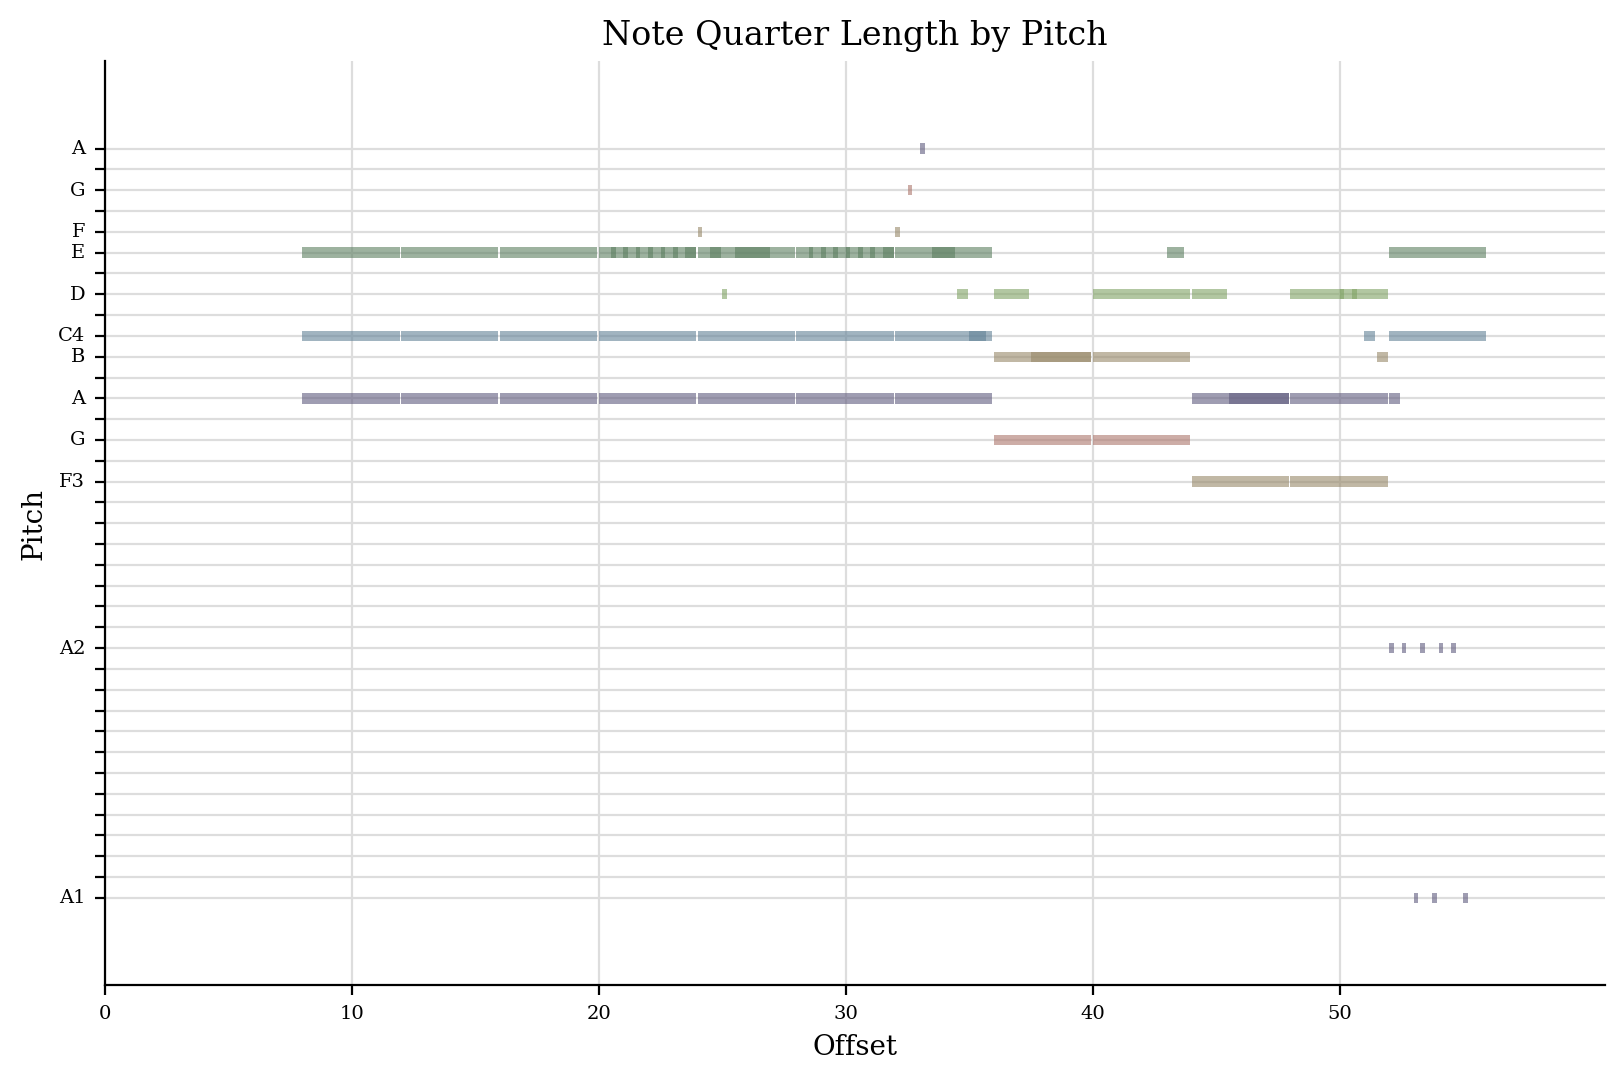

In [91]:
random_test_path = random.choice(test_filepaths)
random_test_idx_score = midifile_to_idx_score(random_test_path, trained_vocab)
random_test_intro = random_test_idx_score[:sample_length]
random_test_intro_stream = idx_to_stream_enc(np.array(random_test_intro[:, 0]), trained_vocab)
random_test_intro_stream.plot()

In [92]:
random_test_intro_stream.show('midi')

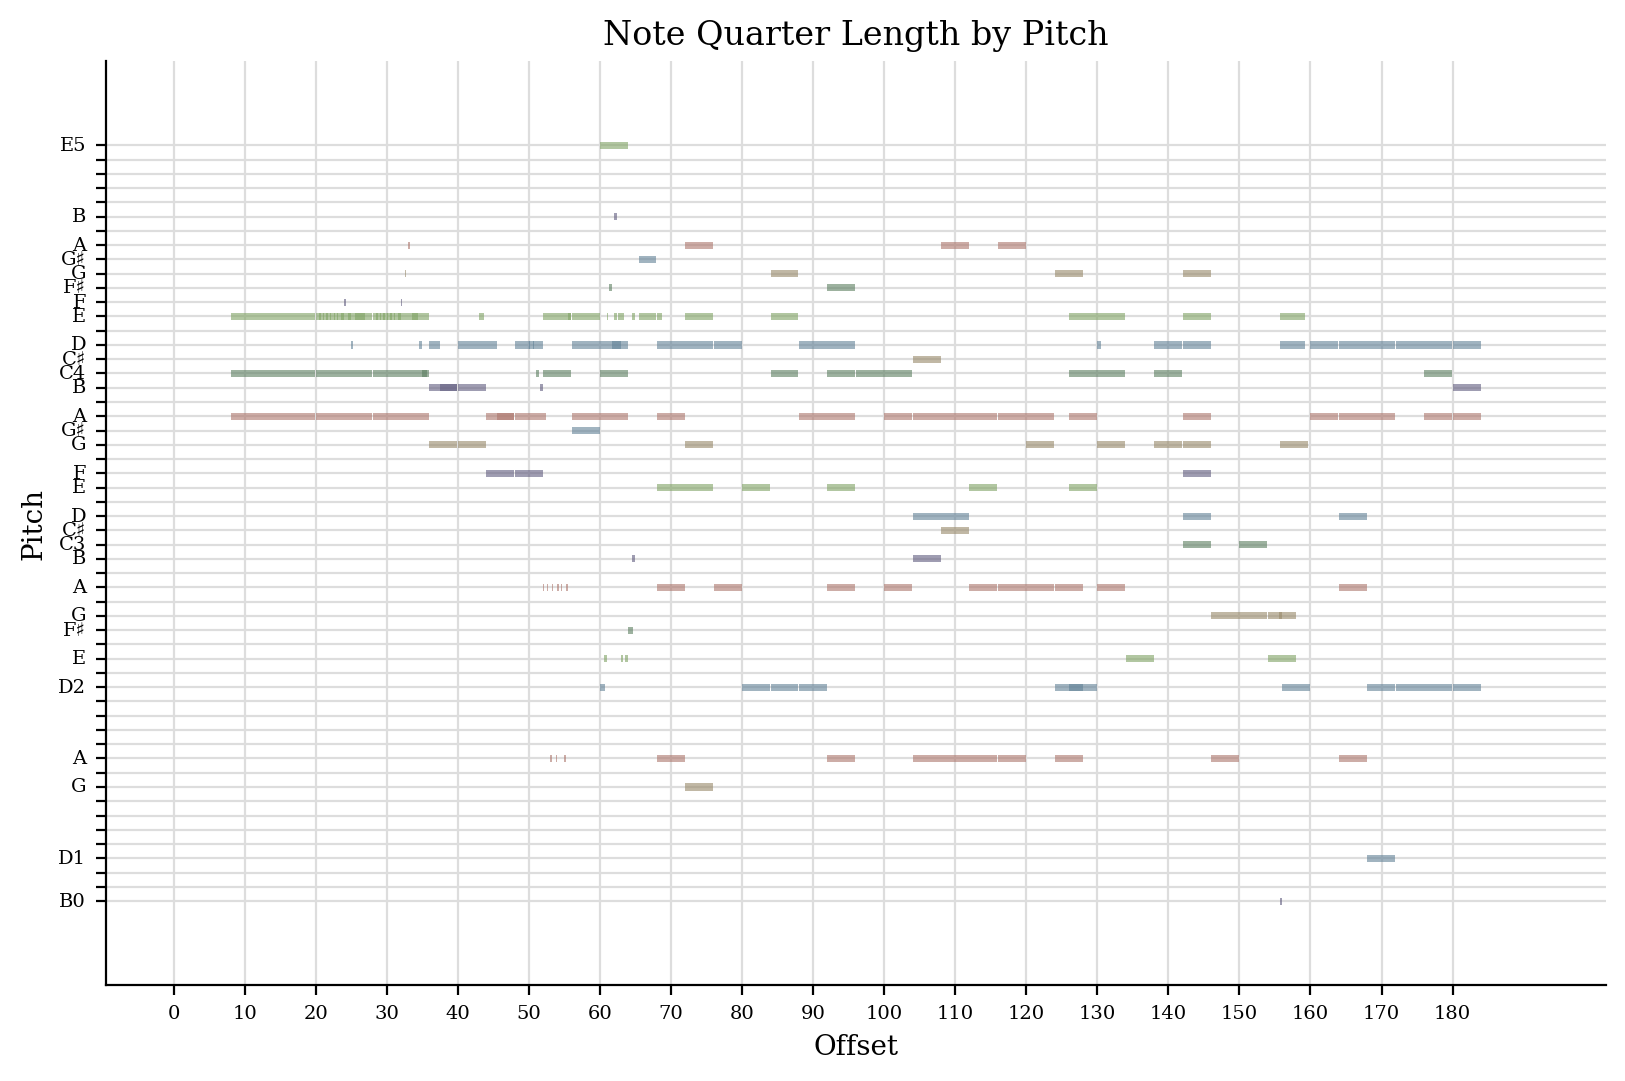

In [99]:
random_test_init = torch.tensor(random_test_intro, device=device).unsqueeze(0)
random_test_continued = model.generate(random_test_init, max_new_tokens=512).cpu()[0, :, 0]
random_test_continued_stream = idx_to_stream_enc(np.array(random_test_continued), trained_vocab)
random_test_continued_stream.plot()

In [100]:
random_test_continued_stream.show('midi')

In [101]:
def group_by_timestep(data, include_position=False):
    grouped = {}
    for idx, position in data:
        if position not in grouped:
            grouped[position] = []
        grouped[position].append(idx)
    
    if include_position:
        result = [(tuple(values), position) for position, values in grouped.items()]
    else:
        result = [tuple(values) for values in grouped.values()]
    return result

data = [[1, 0], [2, 0], [3, 0], [4, 1], [5, 1], [6, 2], [7, 2], [8, 2], [9, 2]]

grouped_data = group_by_timestep(data, include_position=False)
print(grouped_data)

[(1, 2, 3), (4, 5), (6, 7, 8, 9)]


In [102]:
grouped_data = group_by_timestep(data, include_position=True)
print(grouped_data)

[((1, 2, 3), 0), ((4, 5), 1), ((6, 7, 8, 9), 2)]


In [103]:
actions = {}
grouped_idxs = [(1, 2, 3), (4, 5), (6, 7, 8, 9), (1, 2, 3), (1, 2, 3), (6, 7, 8, 9), (4, 5), (4, 5), (4, 5)]
for action in grouped_idxs:
    actions[action] = actions.get(action, 0) + 1
actions

{(1, 2, 3): 3, (4, 5): 4, (6, 7, 8, 9): 2}

In [104]:
sorted_actions = {k: v for k, v in sorted(actions.items(), key=lambda item: item[1], reverse=True)}
sorted_actions

{(4, 5): 4, (1, 2, 3): 3, (6, 7, 8, 9): 2}

In [105]:
top_actions = list(sorted_actions.keys())[:2]
top_actions

[(4, 5), (1, 2, 3)]

In [106]:
initial_size = 10

def try_replace(action, position):
    if action in top_actions:
        return [[initial_size + top_actions.index(action)], position]
    else:
        return [list(action), position]
        
replaced_score = [try_replace(action, position) for action, position in grouped_data]
replaced_score

[[[11], 0], [[10], 1], [[6, 7, 8, 9], 2]]

In [107]:
note_idx_score = []
pos_score = []
for (action, position) in replaced_score:
    for index in action:
        note_idx_score.append(index)
        pos_score.append(position)
note_idx_score

[11, 10, 6, 7, 8, 9]

In [108]:
pos_score

[0, 1, 2, 2, 2, 2]

In [109]:
for idx, action in enumerate(top_actions):
   print(' '.join([str(a) for a in action]))

4 5
1 2 3
